# Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install contractions
!pip install demoji
!pip install scikeras
!pip install nltk
!pip install gensim
!pip install wordninja

In [2]:
import numpy as np
import pandas as pd
import contractions
import demoji
import string
import wordninja
import re
import gensim

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt


import nltk
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load the data

In [3]:
# load data
TRAIN_PATH = "/content/gdrive/MyDrive/EDA/data/Corona_NLP_train.csv"
train_df = pd.read_csv(TRAIN_PATH, encoding="latin_1")

# print a sample of the data
print('Train shape: ', train_df.shape)
train_df.sample(10)

Train shape:  (41157, 6)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
25121,28920,73872,NaN,30-03-2020,As the virus spreads more and more workers are...,Negative
27194,30993,75945,Dubai,03-04-2020,Benchmark #Brent crude oil futures rose as hig...,Extremely Negative
23385,27184,72136,NaN,26-03-2020,You know who s helping us during COVID 19 Medi...,Negative
11354,15153,60105,"Bishopbrigs, Scotland",20-03-2020,shithouses in #Covid_19 @richardbranson @Brita...,Neutral
15299,19098,64050,Bitcoin,22-03-2020,Hurry up while you can still protect your life...,Positive
38506,42305,87257,Harare Zimbabwe,11-04-2020,@daddyhope God didn't allow COVID-19 to origin...,Positive
143,3942,48894,NaN,16-03-2020,IÂve been online shopping for the past 2 days...,Neutral
11190,14989,59941,Nottinghamshire,20-03-2020,@AnnaWeather @sarahjulianotts By tomorrow it w...,Neutral
28086,31885,76837,"Victoria, Australia",04-04-2020,I donÂt understand? #Coles staff are scanning...,Neutral
40615,44414,89366,Worldwide,13-04-2020,SAS' @CChase4628 says restoring balance to the...,Positive


In [4]:
# convert the classes from 5 to 3
# consider "Extremely Positive" and "Positive" a single class of label 2
# consider "Extremely Negative" and "Negative" a single class of label 0
# "Neutral" => label 1
def convert_sentiment(sentiment):
    if sentiment.lower() in ["extremely positive", "positive"]:
        return 2
    elif sentiment.lower() in ["extremely negative", "negative"]:
        return 0
    else:
        return 1

# apply the previously defined function to the 'Sentiment' field
train_df['label'] = train_df['Sentiment'].apply(lambda x : convert_sentiment(x))

# drop the unwanted columns that are not relevant 
train_df = train_df.drop(columns=['UserName', 'ScreenName', 'Location', 'TweetAt'])

# Preprocess the data

In [5]:
def rm_mentions(text):
    return  re.sub(r'@\w+','',text)
    
def rm_hashtags(text):
    return re.sub(r'#\w+','' , text)

def rm_hyperlinks(text):
    return re.sub(r'http\S+', '', text)

def rm_html(text):
    return re.sub('r<.*?>','', text)

def rm_emoji(text):
    return demoji.replace(text)

def uncontract(text):
    return " ".join([contractions.fix(word) for word in text.split()])

def rm_digits(text):
    return re.sub(r'\d+', '', text)

def rm_punkt(text):
    words = []
    for word in text.split():
        res = []
        for chr in word:
            if chr == '/':
                res.append(' ')
            elif chr not in string.punctuation:
                res.append(chr)
        words.append(''.join(res))
    return " ".join(words)

def clean_tweet(text, keep_stops=False):
    text = re.sub(r'â|Â',"\'", text)
    text = rm_mentions(text)    # remove mentions
    text = rm_hashtags(text)    # remove hashtags
    text = rm_hyperlinks(text)  # remove hyperlinks
    text = rm_html(text)        # remove html tags
    text = rm_emoji(text)       # remove emojis
    text = rm_digits(text)      # remove digits
    text = uncontract(text)     # uncontract 
    text = rm_punkt(text)       # split words containing /

    # after preprocessing there is the possibility to have some words that
    # are not separated by space. Separate them.
    text = ' '.join(word for word in wordninja.split(text))

    # keep or not keep stopwords
    if not keep_stops:
        return " ".join([word.lower() for word in text.split() if word not in stopwords.words('english')])

    return text.lower()

train_df['text'] = train_df['OriginalTweet'].apply(lambda x : clean_tweet(x))
train_df

,OriginalTweet,Sentiment,label,text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,1,
1,advice Talk to your neighbours family to excha...,Positive,2,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,Positive,2,coronavirus australia woolworths give elderly ...
3,My food stock is not the only one which is emp...,Positive,2,my food stock one empty please panic there wil...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,me ready go supermarket outbreak not i paranoi...
...,...,...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral,1,airline pilots offering stock supermarket shel...
41153,Response to complaint not provided citing COVI...,Extremely Negative,0,response complaint provided citing c ovid rela...
41154,You know itÂs getting tough when @KameronWild...,Positive,2,you know getting tough rationing toilet paper ...
41155,Is it wrong that the smell of hand sanitizer i...,Neutral,1,is wrong smell hand sanitizer starting turn


In [6]:
# if there are empty entries in the dataset, replace "" with nan in order to remove them
train_df.replace("", np.nan, inplace=True)

# there is an entry in the 'text' field that only contains the word 'and', 
# remove this entry because it will give no relevant information 
train_df.replace("and", np.nan, inplace=True)

train_df.dropna(inplace=True)
# sample the data
train_df.sample(10)

,OriginalTweet,Sentiment,label,text
11546,WhatÂs interesting is what food hasnÂt not b...,Positive,2,interesting food cleared supermarket shelves i...
6372,I'm on this new diet... It's called: whatever ...,Extremely Positive,2,i new diet called whatever i find grocery stor...
36230,England s supermarkets have all failed they ha...,Negative,0,england supermarkets failed colluded shadowy n...
19555,The pandemic plus the fall of prices and a dro...,Negative,0,the pandemic plus fall prices drop demand hitt...
2197,Not sure how many days we are into to this cri...,Extremely Negative,0,not sure many days crisis workers grocery stor...
11299,@jussihulkkonen @FlorenceGaub @DanielFiott @Fo...,Positive,2,agree and i think certain tech develops eg d m...
9876,@AlleyKat2 Here's the direct link. /smug\r\r\n...,Positive,2,direct link smug
21388,NJ Man Who Coughed on Supermarket Worker and T...,Extremely Negative,0,nj man who coughed supermarket worker told her...
12208,The majority of cases relate to online shoppi...,Negative,0,the majority cases relate online shopping scam...
12872,"@nir_eynon Hi Nir, we are releaseing a local e...",Extremely Positive,2,hi nir release ing local economic stimulus pac...


# Feature extraction with Word2Vec

In [7]:
# load the predefined model
word_2vec = gensim.models.KeyedVectors.load_word2vec_format("/content/gdrive/MyDrive/EDA/data/GoogleNews-vectors-negative300.bin", binary=True)

In [8]:
# get embeddings for each tweet in the dataset
# compute the embedding for every word in the sentence, then apply 
# np.mean in order to obtained an embedding for the whole sentence
# in case the Word2Vec model doesn't recognize any word in a sentence
# then set the embedding of that sentence to an array full of 0s
def text_emb(text):
    words = text.split()
    
    vec = []
    for word in words:
        try:
            vec.append(word_2vec[word])
        except Exception as E:
            pass
        
    if len(vec) == 0:
        vec = np.zeros((300,))
    else:
        vec = np.mean(vec, axis=0)
        
    return vec

# apply the function to the data
train_df['emb'] = [text_emb(text) for text in train_df['text']]

# stack the resulting embeddings
# we will consider these embeddings as final features for the model
emb = np.stack(train_df['emb'].to_numpy())
print('Embeddings shape: ', emb.shape)

Embeddings shape:  (41114, 300)


# Preparation for the model

In [9]:
# split the data into train (90%), validation (10%)
X_train , X_val , y_train , y_val = train_test_split(emb, train_df['label'], test_size=0.1, random_state=0)

# print the shapes of the features and labels
print('Train festures: ', X_train.shape)
print('Train labels: ', y_train.shape)

print('Validation features: ', X_val.shape)
print('Validation labels: ', y_val.shape)

Train festures:  (37002, 300)
Train labels:  (37002,)
Validation features:  (4112, 300)
Validation labels:  (4112,)


# Model and Hyperparameter Tuning

In [23]:
# search the best hyperparameters for the model
# try to find the combination of hyperparameters that performs the best
C = [0.01, 1, 1.5, 2]
GAMMA = ['auto', 'scale']
KERNEL = ['linear', 'rbf']

best_accuracy = 0
best_params = {}

for param_c in C:
  for param_kernel in KERNEL:
    if param_kernel == 'rbf':
      for param_gamma in GAMMA:
        # define the model
        model = SVC(C=param_c, gamma=param_gamma, kernel=param_kernel, verbose=True)

        # train the model on training data
        model.fit(np.array(X_train), np.array(y_train))
        
        # predict the model
        y_pred = model.predict(X_val)
        predictions = [round(value) for value in y_pred]

        # evaluate predictions
        accuracy = accuracy_score(y_val, predictions)
        
        print(f'Accuracy: {accuracy} obtained using c={param_c}, gamma={param_gamma}, kernel={param_kernel}')
        
        # save the best parameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params['C'] = param_c
            best_params['kernel'] = param_kernel
            best_params['gamma'] = param_gamma
    else:
      # linear kernel doesn't have kernel coefficient gamma
      # define the model
      model = SVC(C=param_c, kernel=param_kernel, verbose=True)

      # train the model on training data
      model.fit(np.array(X_train), np.array(y_train))
      
      # predict the model
      y_pred = model.predict(X_val)
      predictions = [round(value) for value in y_pred]

      # evaluate predictions
      accuracy = accuracy_score(y_val, predictions)
      
      print(f'Accuracy: {accuracy} obtained using c={param_c}, gamma={param_gamma}, kernel={param_kernel}')
      
      # save the best parameters
      if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_params['C'] = param_c
          best_params['kernel'] = param_kernel
          best_params['gamma'] = param_gamma

[LibSVM]Accuracy: 0.5963035019455253 obtained using c=0.01, gamma=auto, kernel=linear
[LibSVM]Accuracy: 0.4260700389105058 obtained using c=0.01, gamma=auto, kernel=rbf
[LibSVM]Accuracy: 0.5977626459143969 obtained using c=0.01, gamma=scale, kernel=rbf
[LibSVM]Accuracy: 0.6952821011673151 obtained using c=1, gamma=scale, kernel=linear
[LibSVM]Accuracy: 0.58681906614786 obtained using c=1, gamma=auto, kernel=rbf
[LibSVM]Accuracy: 0.7400291828793775 obtained using c=1, gamma=scale, kernel=rbf
[LibSVM]Accuracy: 0.6952821011673151 obtained using c=1.5, gamma=scale, kernel=linear
[LibSVM]Accuracy: 0.5963035019455253 obtained using c=1.5, gamma=auto, kernel=rbf
[LibSVM]Accuracy: 0.7436770428015564 obtained using c=1.5, gamma=scale, kernel=rbf
[LibSVM]Accuracy: 0.6950389105058365 obtained using c=2, gamma=scale, kernel=linear
[LibSVM]Accuracy: 0.6101653696498055 obtained using c=2, gamma=auto, kernel=rbf
[LibSVM]Accuracy: 0.7444066147859922 obtained using c=2, gamma=scale, kernel=rbf


In [11]:
# fit the model with best found hyperparameters
model = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'], verbose=True)
model.fit(np.array(X_train), np.array(y_train))

[LibSVM]

SVC(C=2, verbose=True)

In [12]:
# test the model on validation data
y_pred = model.predict(X_val)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
accuracy

0.7444066147859922

# Test the model on testing data

In [13]:
# load the testing data
TEST_PATH = "/content/gdrive/MyDrive/EDA/data/Corona_NLP_test.csv"
test_df = pd.read_csv(TEST_PATH, encoding="latin_1")

# transform the labels of the test as we did with the train set
test_df['label'] = test_df['Sentiment'].apply(lambda x : convert_sentiment(x))

print('Test shape: ', test_df.shape)
# print a sample of the test set
test_df.sample(10)

Test shape:  (3798, 7)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,label
3721,3722,48674,"Guelph, Canada",16-03-2020,2/9 We live in a wondrous age when global supp...,Negative,0
1995,1996,46948,"Kentucky, USA",13-03-2020,The grocery store was out of every frozen vege...,Neutral,1
997,998,45950,NaN,13-03-2020,"#Coronavirus: nieuw woord geleerd ""statistieke...",Positive,2
1729,1730,46682,"Toronto,ON",13-03-2020,Our Dearset Customers. We wanted to give you s...,Positive,2
2572,2573,47525,United States,14-03-2020,Stores selling out due to #panicbuying? Amazon...,Positive,2
3627,3628,48580,"Danville, CA",16-03-2020,We wanted to provide a quick update to let you...,Positive,2
804,805,45757,#FeedTheBirds #WaterTheBirds,12-03-2020,James Moore: If we close schools to prevent co...,Extremely Positive,2
3437,3438,48390,"Washington, DC",16-03-2020,The supermarket business is booming! #COVID2019,Neutral,1
3521,3522,48474,Oman,16-03-2020,"In light of the current crisis, Companies whic...",Extremely Positive,2
2997,2998,47950,United States,15-03-2020,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,0


In [14]:
# preprocess the test set as we processed the train one
test_df['text'] = test_df['OriginalTweet'].apply(lambda x : clean_tweet(x))

In [17]:
# apply the function to the data
test_df['emb'] = [text_emb(text) for text in test_df['text']]

# stack the resulting embeddings
# we will consider these embeddings as final features for the model
emb_test = np.stack(test_df['emb'].to_numpy())
print('Embeddings shape: ', emb_test.shape)

Embeddings shape:  (3798, 300)


In [18]:
# predict model using test set 
y_pred = model.predict(emb_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(test_df['label'], predictions)
accuracy

0.7338072669826224

# Classification Report

In [19]:
# compute the classification report for the testing data
cr = classification_report(test_df['label'], predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.75      0.76      0.75      1633
           1       0.74      0.56      0.64       619
           2       0.72      0.78      0.75      1546

    accuracy                           0.73      3798
   macro avg       0.73      0.70      0.71      3798
weighted avg       0.73      0.73      0.73      3798



# Confusion Matrix

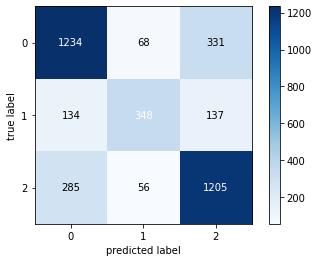

In [20]:
# create confusion matrix for the testing data
cm = confusion_matrix(test_df['label'], predictions)
figure, ax = plot_confusion_matrix(conf_mat=cm, 
                                  colorbar=True)
plt.show()